### Import stuff

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import intake 
import pprint
import xesmf
from CMIP6_Utils import *

In [3]:
import sys  
sys.path.insert(0, '/home/jupyter/InternalVariability/AdaptationAnalysis')

In [4]:
from app.main.src.climate_projection import ClimateProjection
from app.main.src.year_of_departure import *
from app.main.src.datasets import *
from app.main.src.post_processing import BiasCorrection, NoPostProcessing

### CMIP6 analysis for a single location

In [5]:
# set lat/lon 
# lat=3.9
# lon=-53.1

# for global 
lat = slice(None, None)
lon = slice(None, None)

In [6]:
# get datasets via ClimateProjection workflow
# do monthly data first (using daily takes a while to load)
cp = ClimateProjection(
    lat=lat,
    lon=lon,
    variables=['t2m', 't2m_max', 't2m_min', 'tp'],    
    scenario='ssp585',
#     n_models=5,
    projection_name='internal_variability_data_global',
    gcs_bucket='climateai_data_repository',      
    gcs_path='tmp/internal_variability',
    overwrite=False,
    daily=False
)

In [7]:
# # load the data for point location
# #cross validate should always be false
# cp.load(cross_validate=False,check_exist=True)

In [8]:
# for global 
cp.load(cross_validate=False,check_exist=True,
        pp_method={'monthly' : {'t2m':BiasCorrection,
                                't2m_max':BiasCorrection,
                                't2m_min':BiasCorrection,
                                'tp':NoPostProcessing}},
       interp_dx=2.5)

## Reproduce HS09
Here we will reproduce the model uncertainty and internal varaibility estimates using methodology from HS09 (i.e. fitting the data with a 4th order polynomial) 

### Prepare the data 

### test workflow

In [49]:
data = prepare_data(dataset1=cp.raw_hist_monthly,dataset2=cp.raw_future_monthly)

In [13]:
# for global data 
data = data.mean(dim=('lon','lat'))

In [15]:
data_ref = get_reference_data(dataset=cp.raw_hist_monthly,year1='1985',year2='2005')

In [16]:
# global reference
data_ref = data_ref.mean(dim=('lon','lat'))

In [17]:
data_ref

<xarray.DataArray 't2m' ()>
array(5.011556, dtype=float32)

In [55]:
data_global = internal_variability(data=data,data_ref=data_ref,variable='t2m')

In [56]:
data_global

<xarray.Dataset>
Dimensions:        (time: 113, model: 14)
Coordinates:
  * time           (time) datetime64[ns] 1984-01-01 1985-01-01 ... 2096-01-01
  * model          (model) <U16 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'NESM3'
Data variables:
    t2m            (time, model) float32 -0.5328 -0.04766 0.3297 ... 5.054 5.742
    t2m_ref        float32 4.826
    t2m_fit        (time, model) float32 -0.6078 -0.1285 0.1419 ... 5.132 5.746
    internal_fit   float32 0.003959
    model_fit      (time) float32 0.6498 0.6403 0.6317 ... 1.63 1.682 1.737
    total_direct   (time) float32 0.6569 0.6389 0.6399 ... 1.573 1.597 1.616
    total          (time) float32 0.6537 0.6443 0.6357 ... 1.634 1.686 1.74
    internal_frac  (time) float32 0.6057 0.6145 0.6229 ... 0.2424 0.2349 0.2275
    model_frac     (time) float32 99.39 99.39 99.38 99.37 ... 99.76 99.77 99.77

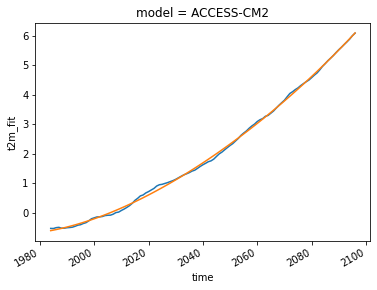

In [57]:
#plot a model and model fit 
data_global.t2m.isel(model=0).plot()
data_global.t2m_fit.isel(model=0).plot()

(0.0, 0.2)

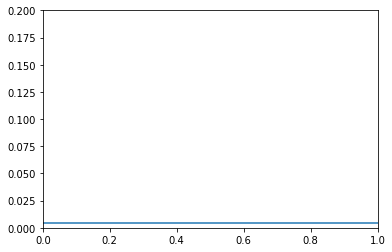

In [58]:
# plot internal variability 
plt.axhline(data_global.internal_fit)
plt.ylim(0,0.2)

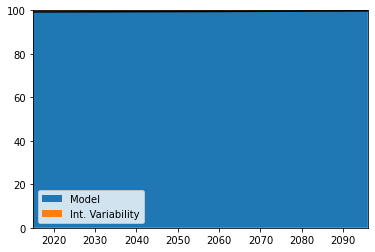

In [59]:
# fractional contribution plot 
x = data_global.time
y = data_global.model_frac
plt.fill_between(x,y,label='Model')
plt.plot(data_global.time,data_global.model_frac,color='k')
plt.fill_between(x,y,100,label='Int. Variability')
plt.xlim(x[31],x[-1])
plt.ylim(0,100)
plt.legend(loc=3)

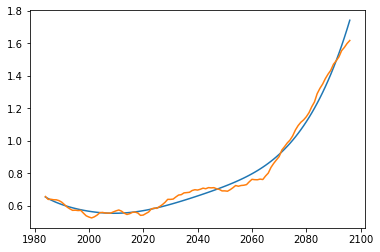

In [60]:
# total uncertainty 
plt.plot(data_global.time,data_global.total)
plt.plot(data_global.time,data_global.total_direct)

In [61]:
# data_global.to_netcdf('/home/jupyter/data/CMIP6_IntVariability_raw_data_global.nc')

### Look at regional and global internal variability

In [5]:
USwest_pp = xr.open_dataset('/home/jupyter/data/CMIP6_IntVariability_pp_USwest.nc')
USeast_pp = xr.open_dataset('/home/jupyter/data/CMIP6_IntVariability_pp_USeast.nc')
europe_pp = xr.open_dataset('/home/jupyter/data/CMIP6_IntVariability_pp_europe.nc')
iceland_pp = xr.open_dataset('/home/jupyter/data/CMIP6_IntVariability_pp_iceland.nc')
australia_pp = xr.open_dataset('/home/jupyter/data/CMIP6_IntVariability_pp_australia.nc')
tropics_pp = xr.open_dataset('/home/jupyter/data/CMIP6_IntVariability_pp_tropics.nc')

In [6]:
USwest_raw = xr.open_dataset('/home/jupyter/data/CMIP6_IntVariability_raw_USwest.nc')
USeast_raw = xr.open_dataset('/home/jupyter/data/CMIP6_IntVariability_raw_USeast.nc')
europe_raw = xr.open_dataset('/home/jupyter/data/CMIP6_IntVariability_raw_europe.nc')
iceland_raw = xr.open_dataset('/home/jupyter/data/CMIP6_IntVariability_raw_iceland.nc')
australia_raw = xr.open_dataset('/home/jupyter/data/CMIP6_IntVariability_raw_australia.nc')
tropics_raw = xr.open_dataset('/home/jupyter/data/CMIP6_IntVariability_raw_tropics.nc')

In [23]:
USwest_pp

<xarray.Dataset>
Dimensions:        (time: 113, model: 14)
Coordinates:
  * time           (time) datetime64[ns] 1984-01-01 1985-01-01 ... 2096-01-01
    lat            float64 ...
    lon            float64 ...
  * model          (model) object 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'NESM3'
Data variables:
    t2m            (time, model) float64 ...
    t2m_ref        float64 ...
    t2m_fit        (time, model) float64 ...
    internal_fit   float64 0.01649
    model_fit      (time) float64 ...
    total_direct   (time) float64 0.006574 0.006833 0.01098 ... 0.6361 0.6382
    total          (time) float64 0.04939 0.04228 0.03657 ... 0.6889 0.698
    internal_frac  (time) float64 ...
    model_frac     (time) float64 66.62 61.0 54.92 48.54 ... 97.58 97.61 97.64

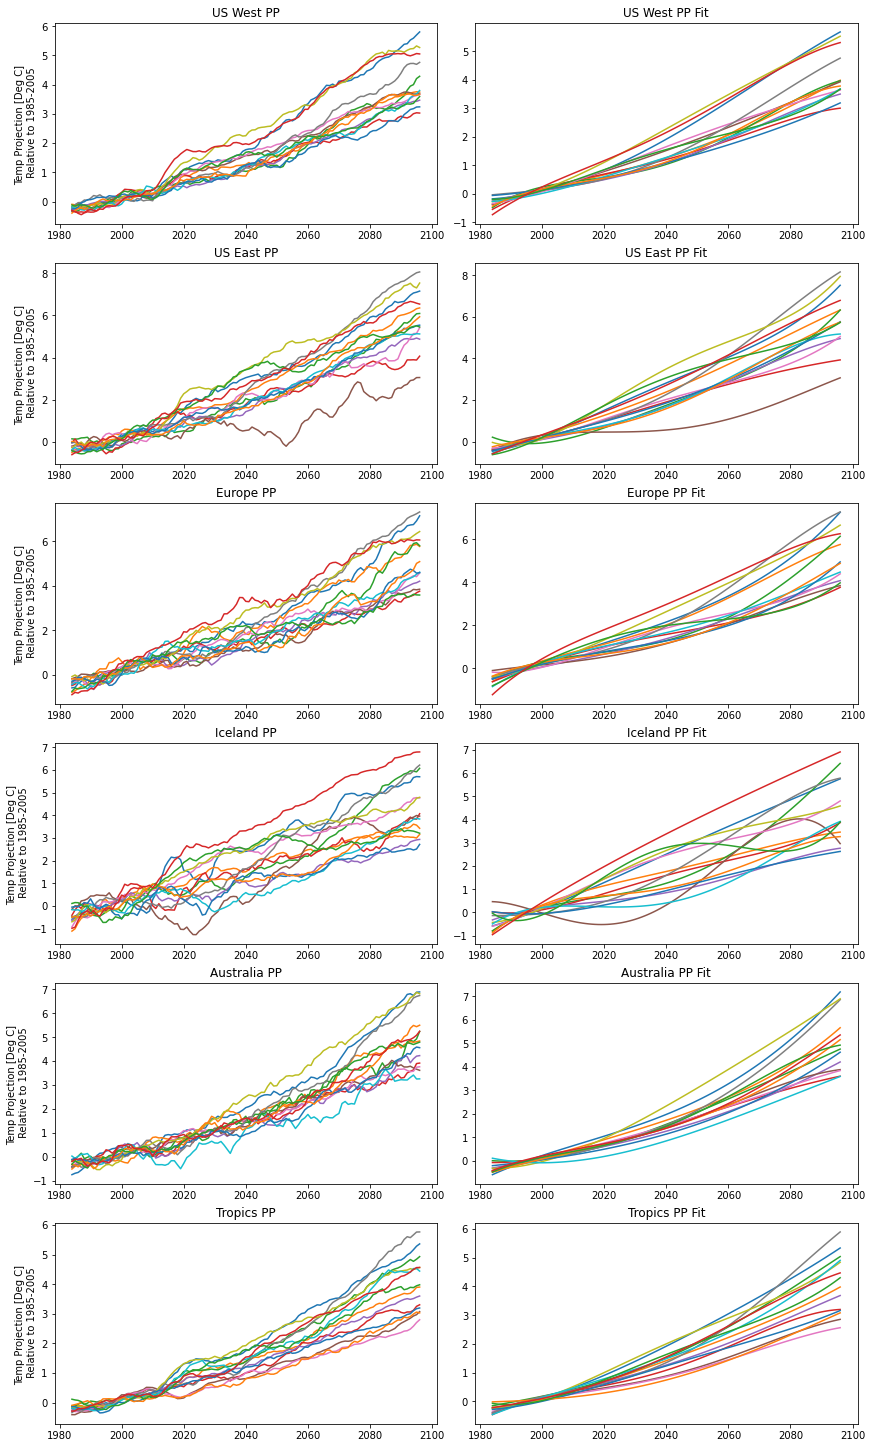

In [27]:
fig,ax = plt.subplots(nrows=6,ncols=2,constrained_layout=True,figsize=(12,20))

regions_pp = [USwest_pp,USeast_pp,europe_pp,iceland_pp,australia_pp,tropics_pp]
axes = np.arange(0,6,1)
titles = ['US West PP','US East PP','Europe PP','Iceland PP','Australia PP','Tropics PP']
for r,i,t in zip(regions_pp,axes,titles):
    for m in range(len(USwest_pp.model)):
        ax[i,0].plot(r.time,r.t2m.isel(model=m))
        ax[i,0].set_title(t)
        ax[i,0].set_ylabel('Temp Projection [Deg C] \n Relative to 1985-2005')

# regions_raw = [USwest_raw,USeast_raw,europe_raw,iceland_raw,australia_raw,tropics_raw]
axes = np.arange(0,6,1)
titles = ['US West PP Fit','US East PP Fit','Europe PP Fit','Iceland PP Fit','Australia PP Fit','Tropics PP Fit']
for r,i,t in zip(regions_pp,axes,titles):
    for m in range(len(USwest_pp.model)):
        ax[i,1].plot(r.time,r.t2m_fit.isel(model=m))
        ax[i,1].set_title(t)
        ax[i,1].set_title(t)

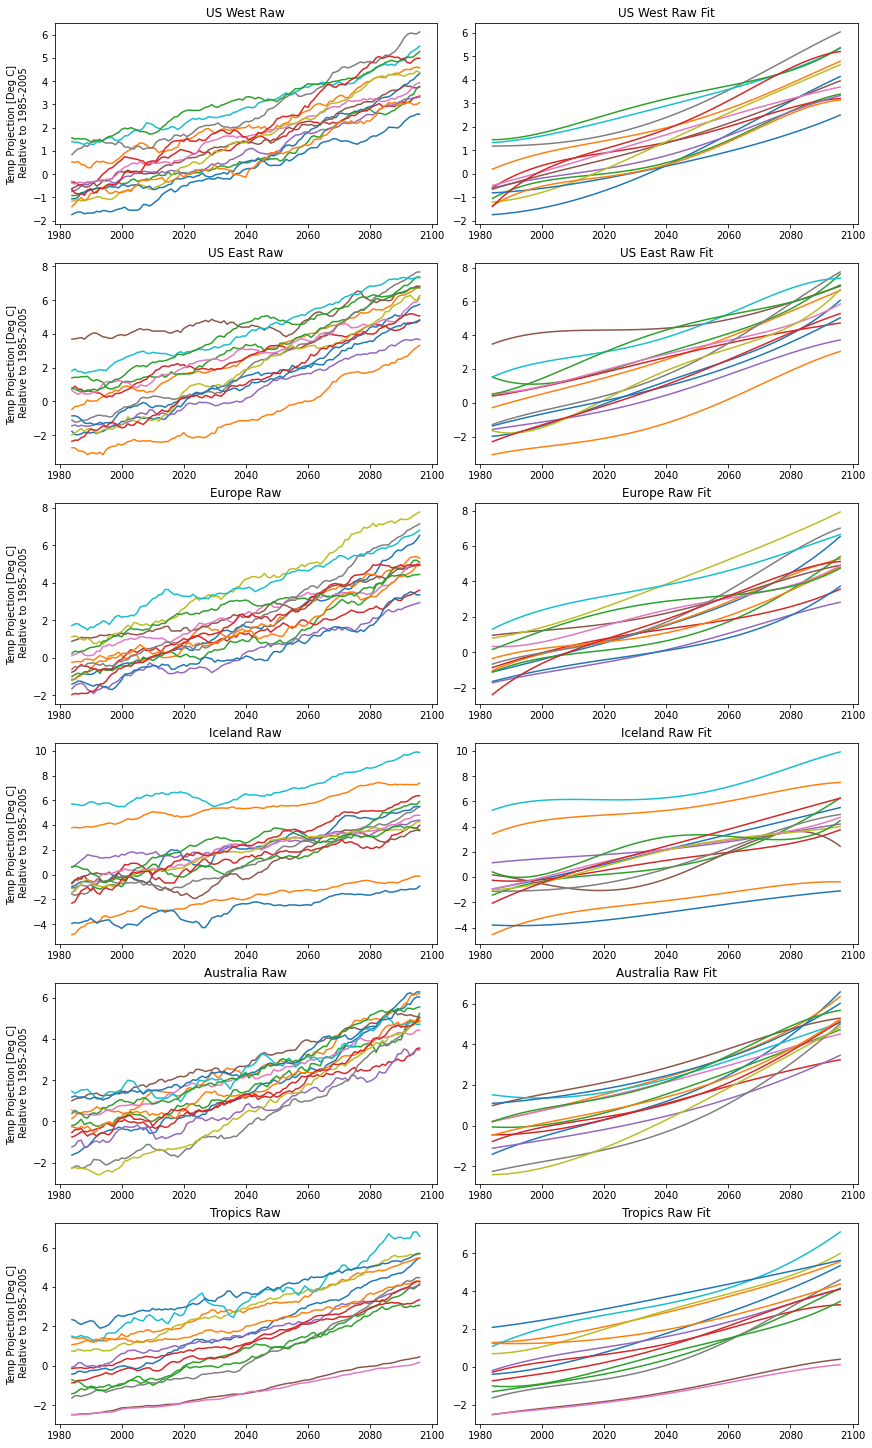

In [28]:
fig,ax = plt.subplots(nrows=6,ncols=2,constrained_layout=True,figsize=(12,20))

regions_raw = [USwest_raw,USeast_raw,europe_raw,iceland_raw,australia_raw,tropics_raw]
axes = np.arange(0,6,1)
titles = ['US West Raw','US East Raw','Europe Raw','Iceland Raw','Australia Raw','Tropics Raw']
for r,i,t in zip(regions_raw,axes,titles):
    for m in range(len(USwest_pp.model)):
        ax[i,0].plot(r.time,r.t2m.isel(model=m))
        ax[i,0].set_title(t)
        ax[i,0].set_ylabel('Temp Projection [Deg C] \n Relative to 1985-2005')

axes = np.arange(0,6,1)
titles = ['US West Raw Fit','US East Raw Fit','Europe Raw Fit','Iceland Raw Fit','Australia Raw Fit','Tropics Raw Fit']
for r,i,t in zip(regions_raw,axes,titles):
    for m in range(len(USwest_pp.model)):
        ax[i,1].plot(r.time,r.t2m_fit.isel(model=m))
        ax[i,1].set_title(t)
        ax[i,1].set_title(t)

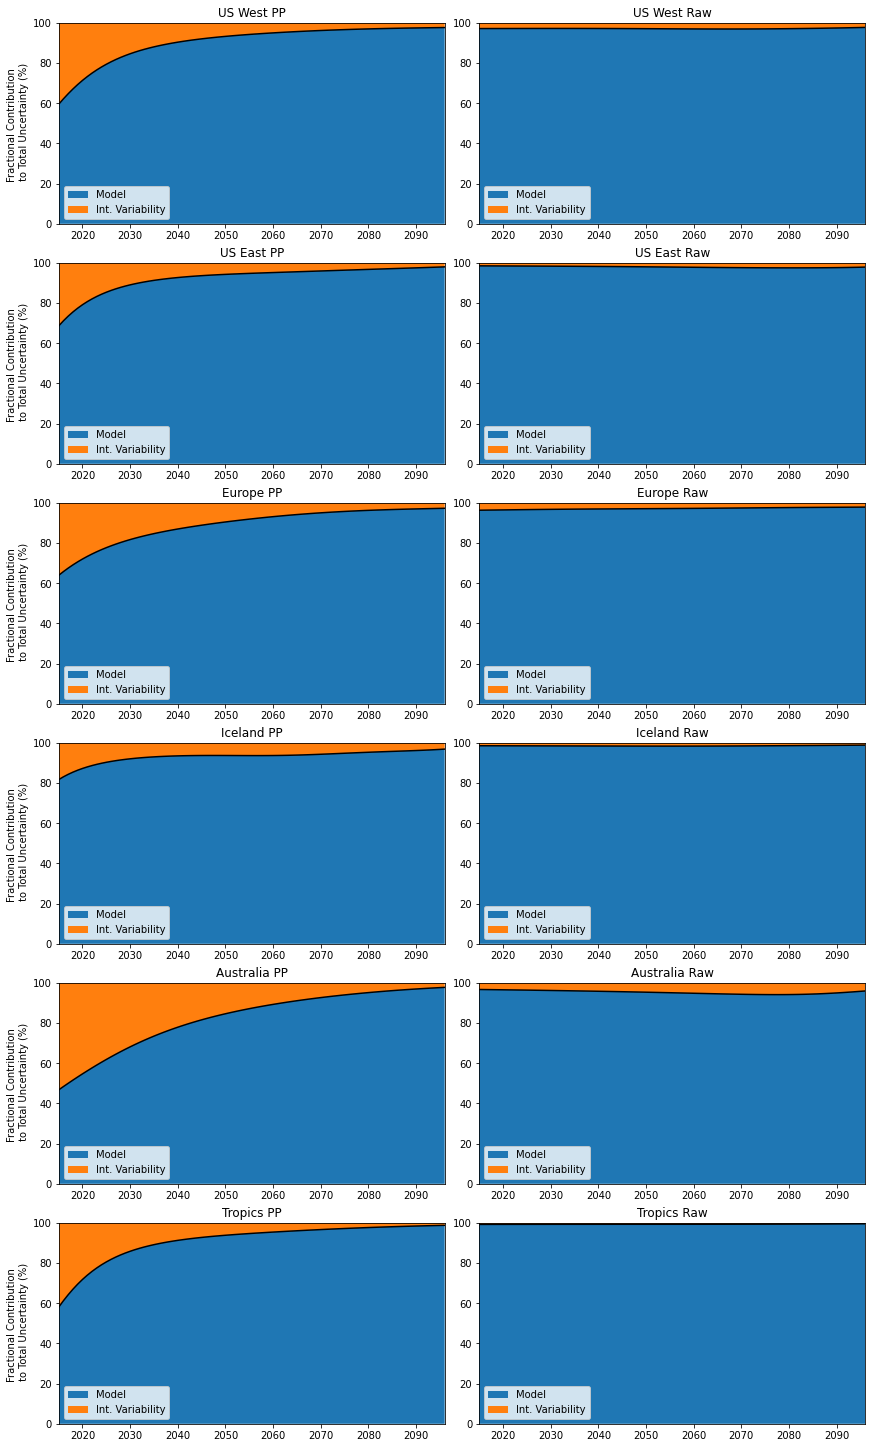

In [10]:
fig,ax = plt.subplots(nrows=6,ncols=2,constrained_layout=True,figsize=(12,20))

regions_pp = [USwest_pp,USeast_pp,europe_pp,iceland_pp,australia_pp,tropics_pp]
axes = np.arange(0,6,1)
titles = ['US West PP','US East PP','Europe PP','Iceland PP','Australia PP','Tropics PP']
for r,i,t in zip(regions_pp,axes,titles):
    x =r.time
    y =r.model_frac
    ax[i,0].fill_between(x,y,label='Model')
    ax[i,0].plot(r.time,r.model_frac,color='k')
    ax[i,0].fill_between(x,y,100,label='Int. Variability')
    ax[i,0].set_xlim(x[31],x[-1])
    ax[i,0].set_ylim(0,100)
    ax[i,0].legend(loc=3)
    ax[i,0].set_title(t)
    ax[i,0].set_ylabel('Fractional Contribution \n to Total Uncertainty (%)')

regions_raw = [USwest_raw,USeast_raw,europe_raw,iceland_raw,australia_raw,tropics_raw]
axes = np.arange(0,6,1)
titles = ['US West Raw','US East Raw','Europe Raw','Iceland Raw','Australia Raw','Tropics Raw']
for r,i,t in zip(regions_raw,axes,titles):
    x = r.time
    y = r.model_frac
    ax[i,1].fill_between(x,y,label='Model')
    ax[i,1].plot(r.time,r.model_frac,color='k')
    ax[i,1].fill_between(x,y,100,label='Int. Variability')
    ax[i,1].set_xlim(x[31],x[-1])
    ax[i,1].set_ylim(0,100)
    ax[i,1].legend(loc=3)
    ax[i,1].set_title(t)

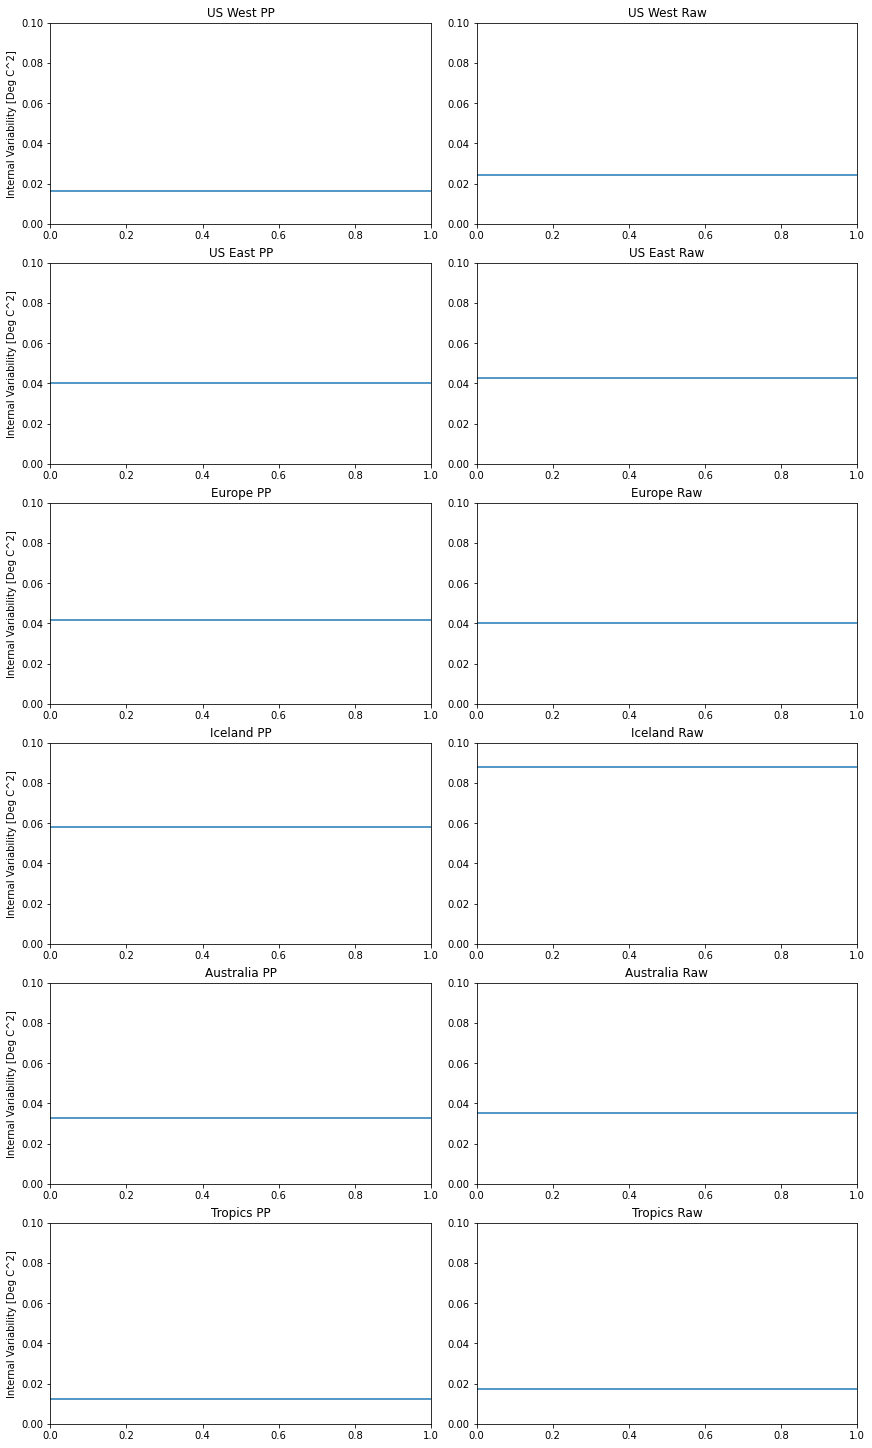

In [14]:
fig,ax = plt.subplots(nrows=6,ncols=2,constrained_layout=True,figsize=(12,20))

regions_pp = [USwest_pp,USeast_pp,europe_pp,iceland_pp,australia_pp,tropics_pp]
axes = np.arange(0,6,1)
titles = ['US West PP','US East PP','Europe PP','Iceland PP','Australia PP','Tropics PP']
for r,i,t in zip(regions_pp,axes,titles):
    ax[i,0].axhline(r.internal_fit)
    ax[i,0].set_ylim(0,0.1)
    ax[i,0].set_title(t)
    ax[i,0].set_ylabel('Internal Variability [Deg C^2]')

regions_raw = [USwest_raw,USeast_raw,europe_raw,iceland_raw,australia_raw,tropics_raw]
axes = np.arange(0,6,1)
titles = ['US West Raw','US East Raw','Europe Raw','Iceland Raw','Australia Raw','Tropics Raw']
for r,i,t in zip(regions_raw,axes,titles):
    ax[i,1].axhline(r.internal_fit)
    ax[i,1].set_ylim(0,0.1)
    ax[i,1].set_title(t)

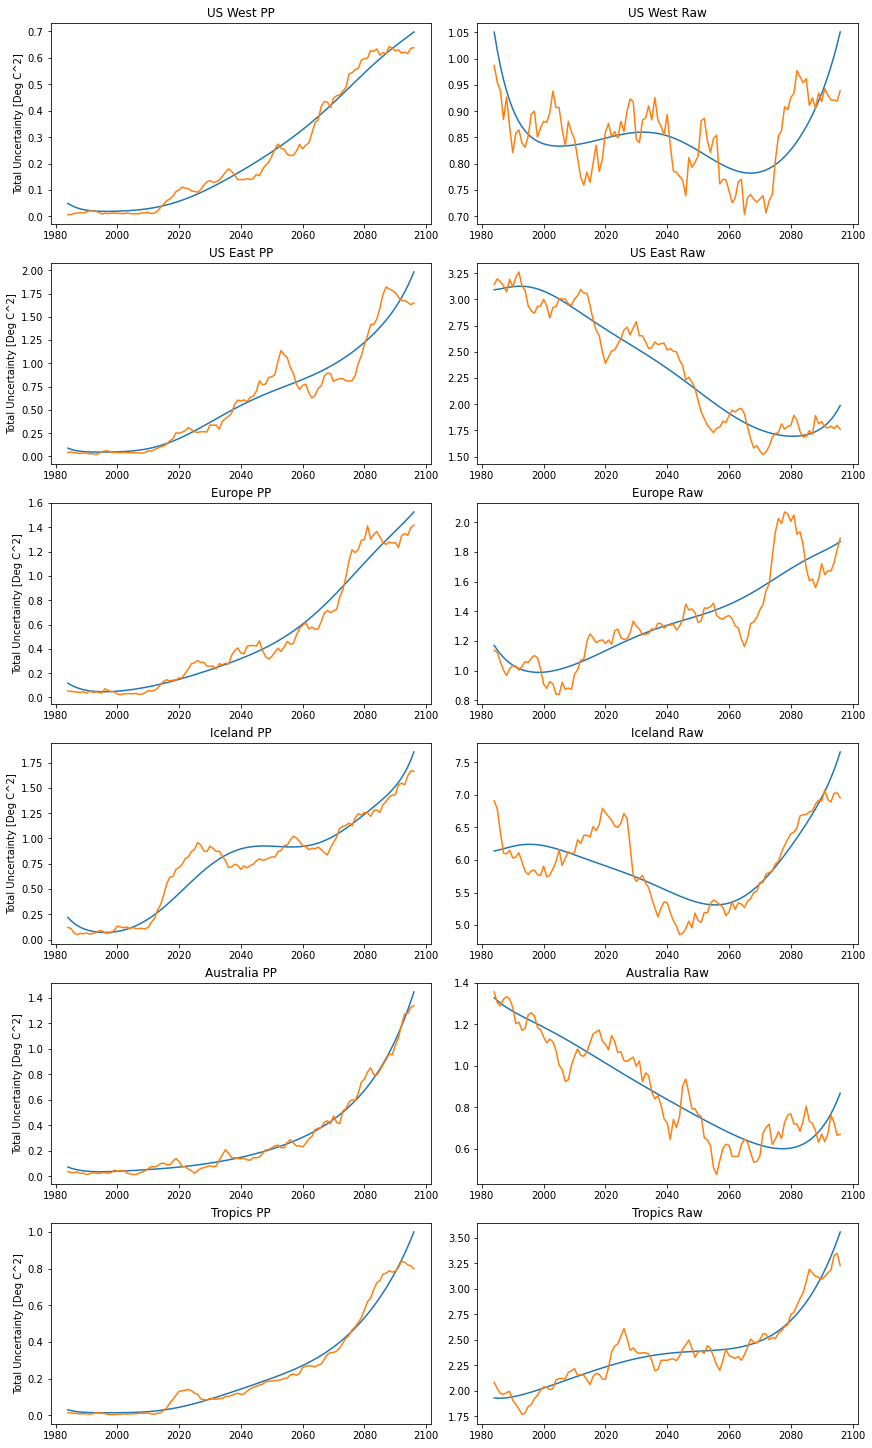

In [16]:

fig,ax = plt.subplots(nrows=6,ncols=2,constrained_layout=True,figsize=(12,20))

regions_pp = [USwest_pp,USeast_pp,europe_pp,iceland_pp,australia_pp,tropics_pp]
axes = np.arange(0,6,1)
titles = ['US West PP','US East PP','Europe PP','Iceland PP','Australia PP','Tropics PP']
for r,i,t in zip(regions_pp,axes,titles):
    ax[i,0].plot(r.time,r.total)
    ax[i,0].plot(r.time,r.total_direct)
    ax[i,0].set_title(t)
    ax[i,0].set_ylabel('Total Uncertainty [Deg C^2]')

regions_raw = [USwest_raw,USeast_raw,europe_raw,iceland_raw,australia_raw,tropics_raw]
axes = np.arange(0,6,1)
titles = ['US West Raw','US East Raw','Europe Raw','Iceland Raw','Australia Raw','Tropics Raw']
for r,i,t in zip(regions_raw,axes,titles):
    ax[i,1].plot(r.time,r.total)
    ax[i,1].plot(r.time,r.total_direct)
    ax[i,1].set_title(t)